## Код программы

In [157]:
# Бинаризация сине-голубой основы карточки для 
# последующего выделения фигур на самих карточках

def get_card_mask(camera, complexBackground=False):
    camera_hsv = color.rgb2hsv(camera) 
    
    # выделение фона
    if complexBackground:
        card_background_lower = camera_hsv[:,:,1]>0.05  
        card_background_upper = (camera_hsv[:,:,0]>0.4) & (camera_hsv[:,:,0]<0.7)
        card_background = card_background_lower & card_background_upper
    else:
        card_background = camera_hsv[:,:,1]>0.3
    
    # отсечение транспортиров и циркулей на самих карточках
    mask1 = camera_hsv[:,:,0]<0.15
    
    # отсечение розовых и сереневых мелков на карточках
    mask2 = camera_hsv[:,:,0]>0.7
    
    # получение основы карточки без лишних элементов на ней
    mask3 = ~(mask1 | mask2)
    
    # отсечение фона
    card_mask = card_background & mask3
    
    # борьба с шумом вне маски и внутри нее
    card_mask = morphology.erosion(card_mask)
    morphology.remove_small_objects(card_mask,500, 8, True)
    morphology.remove_small_holes(card_mask,128, 8, True)
    
    plt.imsave('./process/card_mask.png', card_mask, cmap='gray')
    plt.gcf().clear()
    
    return card_mask

In [158]:
# выделяет картинки на карточках

def get_figures(camera, card_mask):
    
    # перевод изображения в оттенки серого
    # и размытие для лучшего выделения краев
    camera_gray_blur = filters.gaussian(color.rgb2gray(camera), 2)
    
    # выделение краев оператором Собеля
    edges = filters.sobel(camera_gray_blur, mask=card_mask)
    
    # подбор порога для отбора нужных границ
    lower = edges > 0.02
    upper = edges < 0.05
    boundaries = lower & upper
    
    # заливка областей, соответствующих фигурам на картинках
    fill_fig = ndi.binary_fill_holes(boundaries)
    
    # избавляемся от лишнего с помощью морфологии
    fill_fig = morphology.opening(fill_fig, morphology.square(9))
    morphology.remove_small_objects(fill_fig, 1000, 8, True)
    
    plt.imsave('./process/fill_fig.png', fill_fig, cmap='gray')
    plt.gcf().clear()
    
    return fill_fig 

In [159]:
# подсчитывает количество фигурок на карточках, 
# то есть количество карточек

def count_cards(fill_fig):
    label_image = measure.label(fill_fig)
    
    plt.imsave('./process/label_image.png', label_image, cmap='gray')
    
    plt.gcf().clear()
    return label_image.max(), label_image

In [160]:
# нахождение максимального ребра в цепи

def get_max_edge(approx):
    m = 0
    for j in range(1,len(approx)):
        curr = spt.distance.euclidean(approx[j-1], approx[j])
        if curr>m:
            m = curr
    return m

In [161]:
# нахождение средней длины ребра

def get_mean_edge(approx):
    mn = 0
    for j in range(1,len(approx)):
        mn += spt.distance.euclidean(approx[j-1], approx[j])
        
    return mn / (len(approx)-1)

In [162]:
# разбиение всех фигур на два класса: 
# многоугольники и остальные

def classify_fig(fill_fig):
    
    label_image = measure.label(fill_fig)
    
    # данные о связных компонентах
    regions = measure.regionprops(label_image)
    
    # маски для многоугольников и остальных
    polygon_mask = np.zeros(label_image.shape).astype(np.int64)
    other_mask = np.zeros(label_image.shape).astype(np.int64)
    # print(label_image.max())
    
    plt.imshow(fill_fig, cmap='gray')
    
    # пробегаем по всем компонентам связности
    for i in range(label_image.max()):
        # выделяем контур
        contour = measure.find_contours(label_image, i)  # а тут не i+1?
        
        # сохраняем периметр контура
        per = measure.perimeter((label_image==i+1).astype(np.int64))
        
        # аппроксимируем контур более простой кривой 
        # с меньшим числом вершин и 
        # уровень толерантности является
        # необходимым для выделения более длинных ребер
        # у многоугольников, чем у остальных фигур
        approx = measure.approximate_polygon(contour[0], 1)
        
        # выделяем самое длинное ребро из построенного контура
        max_edge = get_max_edge(approx)
        
        # строим первое решающее правило на основе отношения 
        # самого длинного ребра к периметру связной компоненты
        
        ratio_common = 100*max_edge / per
        
        # строим второе решающее правило для выделения
        # "звездочек" на картинках, опираясь на отношение
        # максимальной длины ребра к площади объекта
        
        ratio_star = 1000*max_edge / regions[i].area
        
        
        if ratio_common > 10.8 or ratio_star > 9:
            polygon_mask = polygon_mask | (label_image == i+1)
            plt.plot(approx[:, 1], approx[:, 0], '-b', linewidth=3)
            # print('Polygon: ', i, '; ratio_common:', ratio_common, '; ratio_star:', ratio_star)
        else:
            
            # в данном случае нужна большая толерантность при
            # построении контуров, чтобы отделить многоугольники
            approx = measure.approximate_polygon(contour[0], 1.5)
            max_edge = get_max_edge(approx)
            mean_edge = get_mean_edge(approx)
            
            # критерий для выделения звезд большой площади на картиках
            ratio_massive_star = 100*max_edge*len(approx)/regions[i].area
            
            # критерий для выделения многоугольников, близких по форме к кругу
            # работает не во всех случах, но помогает увеличить точность распознавания
            # пытаемся использовать тот момент, что у многоугольников есть большее 
            # количество длинных отрезков
            ratio_convex_polygon = max_edge - mean_edge
            if ratio_massive_star > 17 and ratio_convex_polygon < 21:
                polygon_mask = polygon_mask | (label_image == i+1)
                plt.plot(approx[:, 1], approx[:, 0], '-y', linewidth=3)
                # print('Polygon: ', i, '; ratio_common:', ratio_common, '; ratio_star:', ratio_star)
                # print('ratio_massive_star: ', ratio_massive_star, 'ratio_convex_polygon: ', ratio_convex_polygon)
            else:
                plt.plot(approx[:, 1], approx[:, 0], '-r', linewidth=3)
                other_mask = other_mask | (label_image == i+1)
                # print('Non-polygon: ', i, '; ratio_common:', ratio_common, '; ratio_star:', ratio_star)
                # print('ratio_massive_star: ', ratio_massive_star, 'ratio_convex_polygon: ', ratio_convex_polygon)
    
    
    plt.axis('off')
    plt.savefig('./process/classification.png', bbox_inches='tight', frameon=False)
    
    # f, (ax1, ax2) = plt.subplots(1,2, sharex=True)
    # ax1.imshow(polygon_mask,cmap='gray')
    # ax2.imshow(other_mask,cmap='gray')
    plt.imsave('./process/polygon_mask.png',polygon_mask, cmap='gray')
    plt.imsave('./process/other_mask.png',other_mask, cmap='gray')
    plt.gcf().clear()
    return (polygon_mask, other_mask)

In [163]:
# выпуклость для многоугольников

def isConvex(polygon_mask, camera):
    # polygon_mask = morphology.erosion(polygon_mask, morphology.square(3))
    # промаркируем полученные многоугольники
    label_image = measure.label(polygon_mask)
    plt.imshow(polygon_mask, cmap='gray')
    
    convex_mask = np.zeros(label_image.shape).astype(np.int64)
    non_convex_mask = np.zeros(label_image.shape).astype(np.int64)
    # найдем выпуклые оболочки для полученных многоугольников
    # print(label_image.max())
    for i in range(label_image.max()):
        # выделяем контур для наглядности рисунка
        contour = measure.find_contours(label_image, i)
        approx = measure.approximate_polygon(contour[0], 1)
        
        # выделяем нужную фигуру
        figure = (label_image == i+1).astype(np.int64)
        
        # подсчитываем площадь многоугольника
        polygon_area = measure.regionprops(figure)[0].area
        
        # считаем выпуклую оболочку
        chull = morphology.convex_hull_image(figure).astype(np.int64)
        
        chull_area = measure.regionprops(chull)[0].area
        
        criteria = (chull_area / polygon_area) - 1
        
        # добавление белых полей
        center_of_mass = ndi.measurements.center_of_mass(label_image==i+1)
        x = center_of_mass[0].astype(int)-15
        y = center_of_mass[1].astype(int)-15
        cv2.rectangle(camera,(y,x),(y+30,x+20),(255,255,255),-1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        if criteria < 0.06:
            convex_mask = convex_mask | (label_image == i+1)
            plt.plot(approx[:, 1], approx[:, 0], '-b', linewidth=3)
            
            # добавление меток
            figures = cv2.putText(camera,'PC',(y+2,x+15), font, 0.6,(255,0,0),2,cv2.LINE_AA)
            
        else:
            non_convex_mask = non_convex_mask | (label_image == i+1)
            plt.plot(approx[:, 1], approx[:, 0], '-r', linewidth=3)
            
            figures = cv2.putText(camera,'P',(y+2,x+15), font, 0.6,(255,0,0),2,cv2.LINE_AA)
            
        # print('Figure: ', i+1, '; criteria: ', criteria)
    
    plt.axis('off')
    plt.savefig('./process/convex.png', bbox_inches='tight', frameon=False)
    plt.imsave('./process/labelling.png',camera)
    plt.gcf().clear()
    return (convex_mask, non_convex_mask)

## Демонстрация

In [165]:
from skimage import io
from skimage import color, filters, feature, morphology
from skimage import segmentation, measure
from skimage import img_as_uint
from scipy import ndimage as ndi
from scipy import spatial as spt

import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 10.0]

def main(filename, complexBackground):
    camera = io.imread('./Sample/IMG7.jpg')
    camera_original = camera.copy()
    camera_hsv = color.rgb2hsv(camera) 
    camera_gray = color.rgb2gray(camera)
    camera_gray_blur = filters.gaussian(camera_gray, 2)

    card_mask = get_card_mask(camera, complexBackground)
    fill_fig = get_figures(camera, card_mask)
    cards_num, label_image = count_cards(fill_fig)
    polygon_mask, other_mask = classify_fig(fill_fig)
    convex_mask, non_convex_mask = isConvex(polygon_mask, camera)

filename = './Sample/IMG7.jpg'
# complexBackground == True для пестрого фона и == False для белого
complexBackground = True
main(filename, complexBackground)

<Figure size 864x720 with 0 Axes>

### Исходное изображение

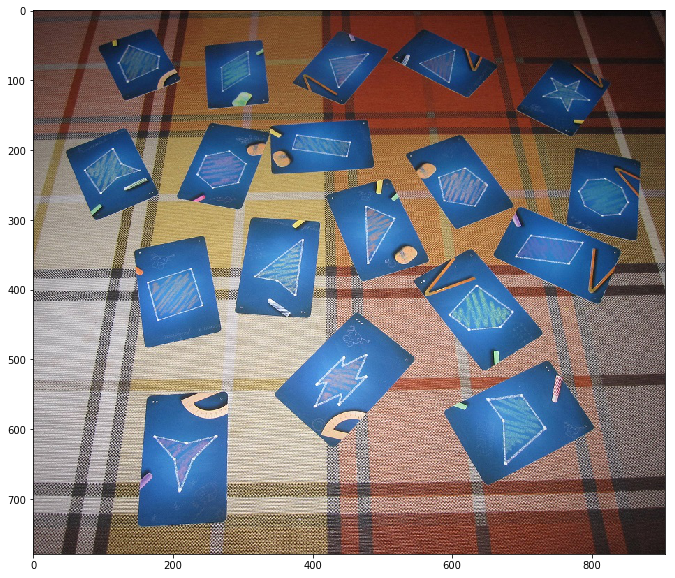

In [166]:
plt.imshow(camera_original)

### Маска для фона карточек

Text(0.5,1,'Результат выделения фона карточек')

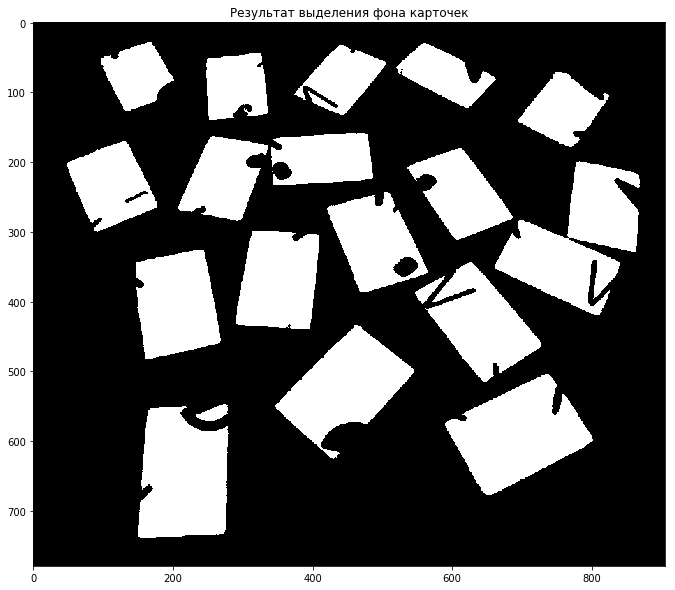

In [167]:
f, ax = plt.subplots()
ax.imshow(card_mask,cmap='gray')
ax.set_title('Результат выделения фона карточек')

### Маска для фигурок на карточках

Text(0.5,1,'Результат выделения фигурок на карточках')

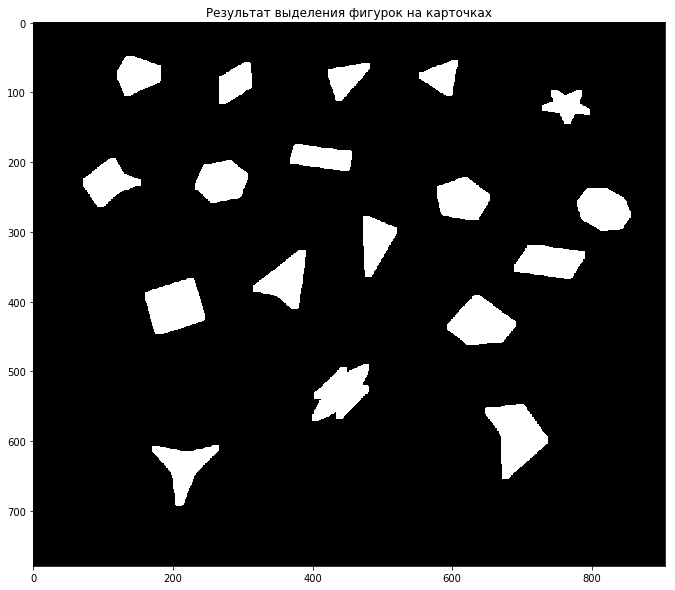

In [168]:
f, ax = plt.subplots()
ax.imshow(fill_fig,cmap='gray')
ax.set_title('Результат выделения фигурок на карточках')

### Количество карточек

Количество карточек равно:  18


Text(0.5,1,'Результат подсчета количества связных компонент')

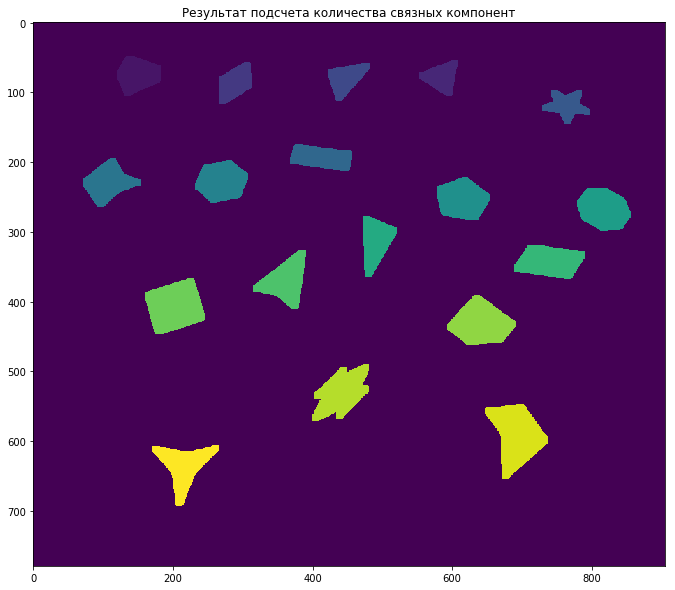

In [169]:
f, ax = plt.subplots()
print('Количество карточек равно: ', cards_num)
ax.imshow(label_image)
ax.set_title('Результат подсчета количества связных компонент')

### Маски для многоугольников и для фигур с гладкими границами

Text(0.5,1,'Маска для фигур с гладкими границами')

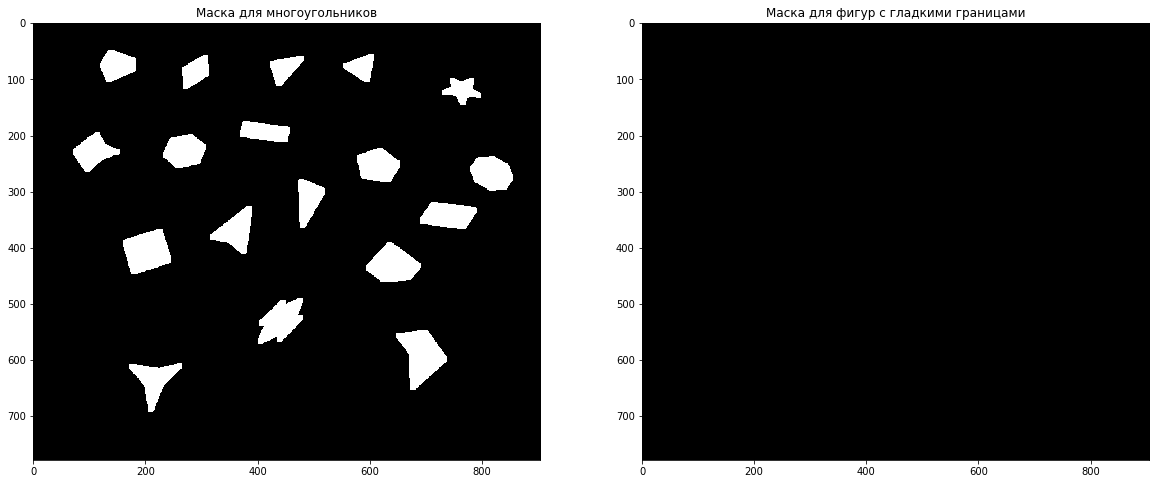

In [170]:
plt.rcParams["figure.figsize"] = [20.0, 16.0]

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.imshow(polygon_mask,cmap='gray')
ax1.set_title('Маска для многоугольников')
ax2.imshow(other_mask,cmap='gray')
ax2.set_title('Маска для фигур с гладкими границами')

### Маски для выпуклых и невыпуклых многоугольников 

Text(0.5,1,'Маска для невыпуклых многоугольников')

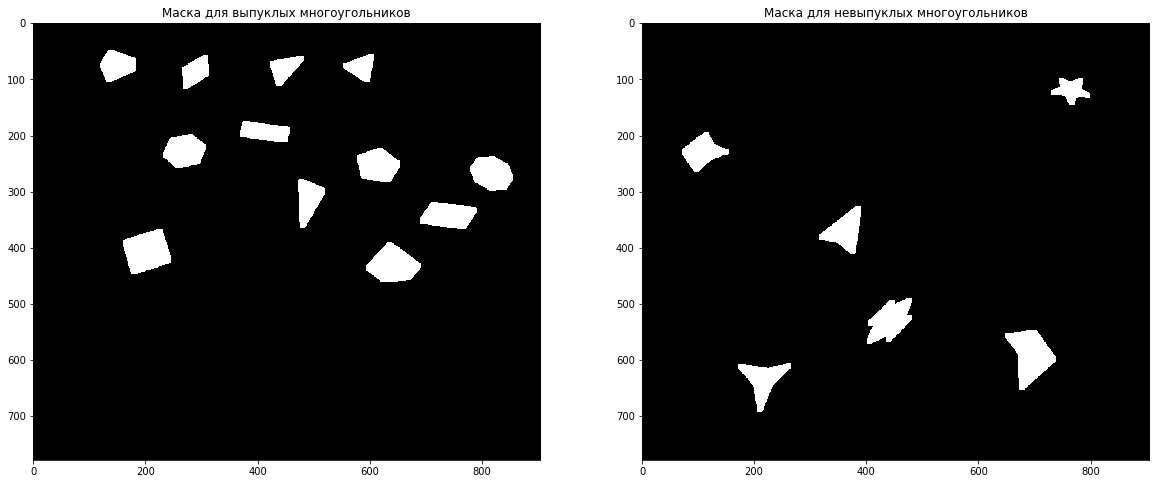

In [171]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
ax1.imshow(convex_mask,cmap='gray')
ax1.set_title('Маска для выпуклых многоугольников')
ax2.imshow(non_convex_mask,cmap='gray')
ax2.set_title('Маска для невыпуклых многоугольников')

### Результат работы программы

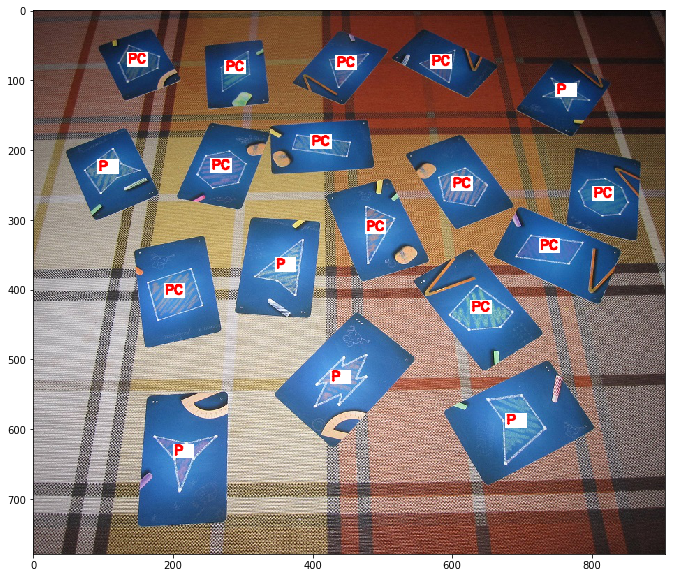

In [172]:
plt.rcParams["figure.figsize"] = [12.0, 10.0]
plt.imshow(camera)